In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from glob import glob
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Input, Lambda
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications import ResNet50

### Splitting folder into train, test, val folder

In [2]:
# skip this if you've already run it

import splitfolders

input_folder = "pisang" #Enter Input Folder
output = "dataset2" #Enter Output Folder

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8,0.15,0.05))

Copying files: 1002 files [00:48, 20.63 files/s]


#### Check image 

Pisang kulit luka


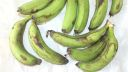



Pisang kulit tidak luka


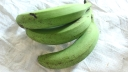

In [14]:
listOfImageNames = ['dataset/train/pisang-kulit-luka/IMG_0003.jpg',
                   'dataset/train/pisang-kulit-tidak-luka/IMG_0022.jpg']

labels = ['Pisang kulit luka', 'Pisang kulit tidak luka']
for i,imageName in enumerate(listOfImageNames):
    print(labels[i])
    display(Image(filename=imageName))
    print("\n")

In [15]:
imgs = cv2.imread("dataset/train/pisang-kulit-luka/IMG_0003.jpg")

In [16]:
imgs.shape

(72, 128, 3)

### Data augmentation

For the documentation of data augment, please follow this link https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [3]:
train_data_gen = ImageDataGenerator(
                    rescale = 1./255,
                    shear_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.2,
                    rotation_range = 40,
                    width_shift_range= 0.2,
                    height_shift_range= 0.2,
                    fill_mode='nearest')

validate_data_gen = ImageDataGenerator(
                    rescale = 1./255)

test_data_gen = ImageDataGenerator(
                    rescale = 1./255)

In [4]:
train_data =  train_data_gen.flow_from_directory(
                        "dataset2/train",
                        target_size=(128,128),
                        batch_size=32,
                        class_mode='categorical')

validate_data = validate_data_gen.flow_from_directory(
                        "dataset2/val",
                        target_size=(128,128),
                        batch_size=32,
                        class_mode='categorical')

test_data =  test_data_gen.flow_from_directory(
                        "dataset2/test",
                        target_size=(128,128),
                        batch_size=32,
                        class_mode='categorical')

Found 801 images belonging to 2 classes.
Found 149 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


## Building Model

### Follow the link below for more detailed explanation

#### Model
- CNN : https://medium.com/@draj0718/convolutional-neural-networks-cnn-architectures-explained-716fb197b243 <br>
- VGG16 : https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16 | https://keras.io/api/applications/vgg/ <br>
- Resnet50 : https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 | https://keras.io/api/applications/resnet/ <br>
- EarlyStopping : https://keras.io/api/callbacks/early_stopping/ <br>
- Adam optimizer : https://keras.io/api/optimizers/adam/ | https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam <br>
- Metric accuracy : https://keras.io/api/metrics/accuracy_metrics/#accuracy-class <br>
- Layers : https://keras.io/api/layers/


### CNN Model

In [53]:
# CNN Model
modelcnn = Sequential()

# 1st layer CNN
modelcnn.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=[128,128,3]))
modelcnn.add(MaxPool2D(pool_size=2,padding='same'))
modelcnn.add(BatchNormalization())
modelcnn.add(Dropout(0.2))

# 2nd layer CNN
modelcnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
modelcnn.add(MaxPool2D(pool_size=2,padding='same'))
modelcnn.add(BatchNormalization())
modelcnn.add(Dropout(0.2))

# 3rd layer CNN
modelcnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
modelcnn.add(MaxPool2D(pool_size=2,padding='same'))
modelcnn.add(BatchNormalization())
modelcnn.add(Dropout(0.2))

# 4th layer CNN
modelcnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
modelcnn.add(MaxPool2D(pool_size=2,padding='same'))
modelcnn.add(BatchNormalization())
modelcnn.add(Dropout(0.2))

modelcnn.add(Flatten())
modelcnn.add(Dense(515,activation='relu'))
modelcnn.add(Dense(2,activation='softmax'))

modelcnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 73, 73, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 73, 73, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)      

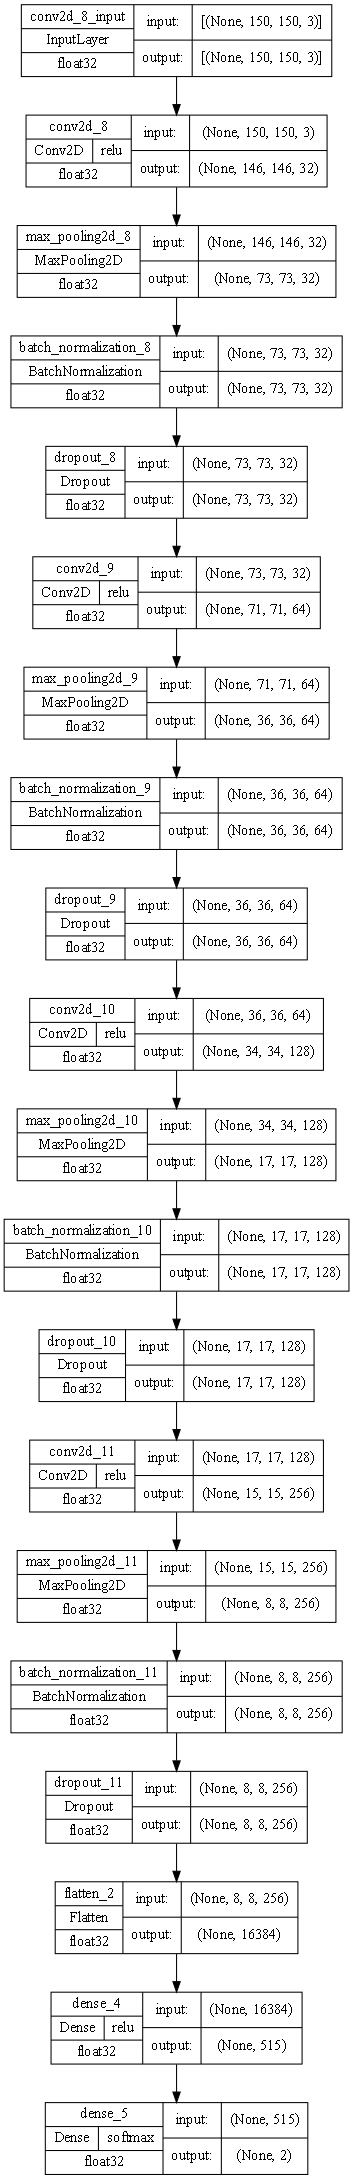

In [59]:
# Get a visual view of the architecture
keras.utils.plot_model(modelcnn, to_file='arsitektur-model/modelcnn.png', show_shapes=True, show_dtype=True, 
                       show_layer_names=True, expand_nested=True,
                       dpi=75, show_layer_activations=True,
)

In [55]:
# Create earlystopping for callback
es = EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [56]:
# Compile the model
modelcnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
# Fit the model
modelcnn.fit(train_data,
          verbose=1,
          validation_data=validate_data,
          batch_size=64,
          epochs=50,
          callbacks=[es])

Epoch 1/50
700/700 [==============================] - 20s 27ms/step - loss: 4.3138 - accuracy: 0.5557 - val_loss: 0.6930 - val_accuracy: 0.6000
Epoch 2/50
700/700 [==============================] - 19s 28ms/step - loss: 1.0304 - accuracy: 0.6014 - val_loss: 1.0235 - val_accuracy: 0.6250
Epoch 3/50
700/700 [==============================] - 21s 31ms/step - loss: 0.7759 - accuracy: 0.6543 - val_loss: 0.6645 - val_accuracy: 0.6350
Epoch 4/50
700/700 [==============================] - 20s 29ms/step - loss: 0.7542 - accuracy: 0.6571 - val_loss: 0.6612 - val_accuracy: 0.6200
Epoch 5/50
700/700 [==============================] - 20s 29ms/step - loss: 0.7288 - accuracy: 0.7057 - val_loss: 0.6539 - val_accuracy: 0.5850
Epoch 6/50
700/700 [==============================] - 20s 29ms/step - loss: 0.5909 - accuracy: 0.7571 - val_loss: 0.6051 - val_accuracy: 0.6950
Epoch 7/50
700/700 [==============================] - 21s 30ms/step - loss: 0.5700 - accuracy: 0.7571 - val_loss: 0.6298 - val_accuracy:

In [60]:
# Creating dataframe of losses and accuracies of model
losses = modelcnn.history.history
df_loss = pd.DataFrame(losses)

In [61]:
df_loss.sort_values(by='val_accuracy',ascending=False).head()

,loss,accuracy,val_loss,val_accuracy
9,0.525545,0.774286,0.462436,0.800
11,0.480673,0.815714,0.517922,0.765
8,0.569969,0.738571,0.562659,0.730
5,0.590897,0.757143,0.605062,0.695
12,0.460944,0.805714,0.575272,0.675


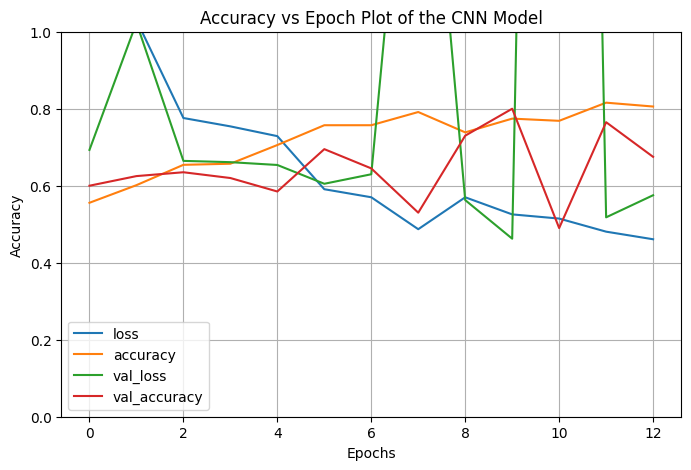

In [62]:
# Visualizing the performance of model

pd.DataFrame(modelcnn.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_ylim(0, 1)
plt.title('Accuracy vs Epoch Plot of the CNN Model')
plt.show()

In [63]:
# Evaluasi model
loss, accuracy= modelcnn.evaluate(test_data)
print(f'Accuracy: {accuracy*100}')

102/102 [==============================] - 1s 8ms/step - loss: 0.5373 - accuracy: 0.7255
Accuracy: 72.54902124404907


In [64]:
# Save model
modelcnn.save('model/modelcnn.h5')

#### #2

In [5]:
# CNN Model
modelcnn2 = Sequential()

# 1st layer CNN
modelcnn2.add(Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=[128,128,3]))
modelcnn2.add(MaxPool2D(2,2))

# 2nd layer CNN
modelcnn2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
modelcnn2.add(MaxPool2D(2,2))

# 3rd layer CNN
modelcnn2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
modelcnn2.add(MaxPool2D(2,2))

# 4th layer CNN
modelcnn2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
modelcnn2.add(MaxPool2D((2,2), strides=2))
modelcnn2.add(Dropout(0.3))

modelcnn2.add(Flatten())
modelcnn2.add(Dense(126,activation='relu'))
modelcnn2.add(Dense(2,activation='softmax'))

modelcnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0

In [6]:
modelcnn2.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [7]:
# Fit the model
modelcnn2.fit(train_data,
          verbose=1,
          validation_data=validate_data,
          batch_size=32,
          epochs=15)

Epoch 1/15
26/26 [==============================] - 107s 792ms/step - loss: 0.6855 - accuracy: 0.5780 - val_loss: 0.6014 - val_accuracy: 0.7315
Epoch 2/15
26/26 [==============================] - 3s 127ms/step - loss: 0.6921 - accuracy: 0.5780 - val_loss: 0.6688 - val_accuracy: 0.5973
Epoch 3/15
26/26 [==============================] - 4s 135ms/step - loss: 0.6705 - accuracy: 0.6005 - val_loss: 0.6327 - val_accuracy: 0.5973
Epoch 4/15
26/26 [==============================] - 6s 212ms/step - loss: 0.5868 - accuracy: 0.6879 - val_loss: 0.4980 - val_accuracy: 0.7517
Epoch 5/15
26/26 [==============================] - 6s 217ms/step - loss: 0.4932 - accuracy: 0.7778 - val_loss: 0.3776 - val_accuracy: 0.8523
Epoch 6/15
26/26 [==============================] - 6s 228ms/step - loss: 0.4206 - accuracy: 0.8227 - val_loss: 0.2626 - val_accuracy: 0.8926
Epoch 7/15
26/26 [==============================] - 5s 194ms/step - loss: 0.3093 - accuracy: 0.8764 - val_loss: 0.2581 - val_accuracy: 0.8993
Epoc

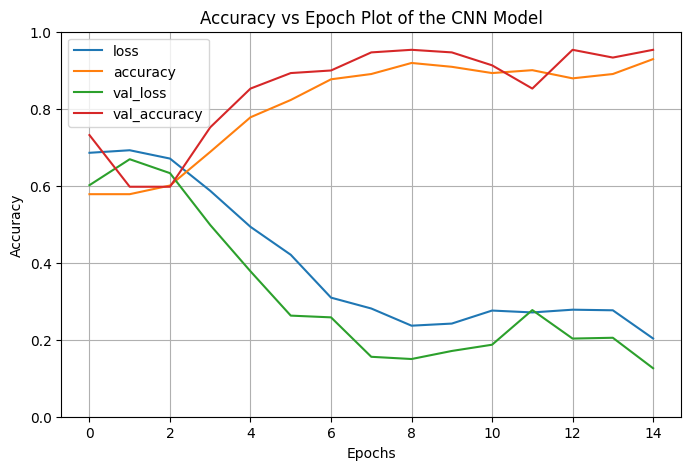

In [8]:
# Visualizing the performance of model
pd.DataFrame(modelcnn2.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_ylim(0, 1)
plt.title('Accuracy vs Epoch Plot of the CNN Model')
plt.show()

In [9]:
modelcnn2.evaluate(test_data)

2/2 [==============================] - 1s 556ms/step - loss: 0.3722 - accuracy: 0.9038


[0.3722253441810608, 0.9038461446762085]

### VGG16 Model

In [68]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
vgg.trainable = False

In [69]:
# our layers - you can add more if you want
inputs = keras.Input(shape=(150, 150, 3))
X = vgg(inputs,training=False)
X = MaxPool2D()(X)
X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dense(2, activation='softmax')(X)

# create a model object
modelvgg16 = Model(inputs=inputs, outputs=X)

In [70]:
# view the structure of the model
modelvgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 2, 512)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dense_9 (Dense)             (None, 2)                 1026      
                                                           

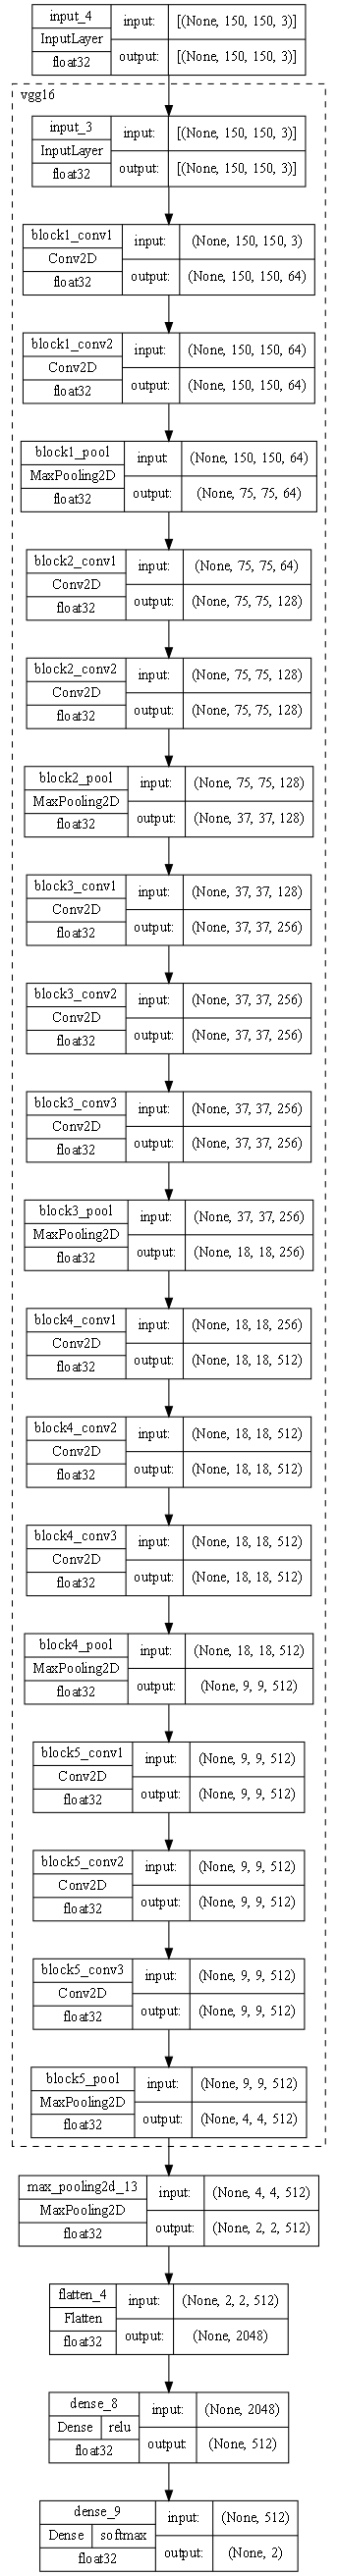

In [71]:
# Get a visual view of the architecture
keras.utils.plot_model(modelvgg16, to_file='arsitektur-model/modelvgg16.png', show_shapes=True, show_dtype=True, 
                       show_layer_names=True, expand_nested=True, 
                       dpi=75, show_layer_activations=True,
)

In [80]:
# compile the model
modelvgg16.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [81]:
# fit the model
modelvgg16.fit(train_data,
             validation_data=validate_data,
             epochs=15,
             steps_per_epoch=len(train_data),
             validation_steps=len(test_data),
             callbacks=[es]
            )

Epoch 1/15
700/700 [==============================] - 38s 53ms/step - loss: 0.2535 - accuracy: 0.9043 - val_loss: 0.2439 - val_accuracy: 0.9216
Epoch 2/15
700/700 [==============================] - 37s 53ms/step - loss: 0.2275 - accuracy: 0.9014 - val_loss: 0.2721 - val_accuracy: 0.9118
Epoch 3/15
700/700 [==============================] - 41s 58ms/step - loss: 0.2649 - accuracy: 0.8957 - val_loss: 0.3839 - val_accuracy: 0.8039
Epoch 4/15
700/700 [==============================] - 41s 59ms/step - loss: 0.2320 - accuracy: 0.9057 - val_loss: 0.1998 - val_accuracy: 0.9216
Epoch 5/15
700/700 [==============================] - 46s 66ms/step - loss: 0.2538 - accuracy: 0.9057 - val_loss: 0.1943 - val_accuracy: 0.9118
Epoch 6/15
700/700 [==============================] - 41s 59ms/step - loss: 0.1888 - accuracy: 0.9229 - val_loss: 0.2176 - val_accuracy: 0.9020
Epoch 7/15
700/700 [==============================] - 44s 63ms/step - loss: 0.2245 - accuracy: 0.9171 - val_loss: 0.2466 - val_accuracy:

In [82]:
# Creating dataframe of losses and accuracies of model
losses = modelvgg16.history.history
df_loss = pd.DataFrame(losses)

In [83]:
df_loss.sort_values(by='val_accuracy',ascending=False).head()

,loss,accuracy,val_loss,val_accuracy
0,0.253488,0.904286,0.243933,0.921569
3,0.231971,0.905714,0.199836,0.921569
1,0.227468,0.901429,0.272080,0.911765
4,0.253812,0.905714,0.194337,0.911765
5,0.188838,0.922857,0.217562,0.901961


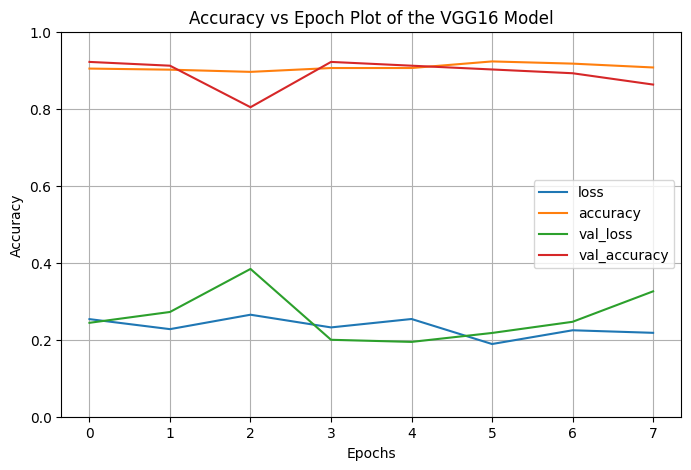

In [84]:
# Visualizing the performance of model
pd.DataFrame(modelvgg16.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_ylim(0, 1)
plt.title('Accuracy vs Epoch Plot of the VGG16 Model')
plt.show()

In [85]:
# Evaluasi model
loss, accuracy= modelvgg16.evaluate(test_data)
print(f'Accuracy: {accuracy*100}')

102/102 [==============================] - 5s 51ms/step - loss: 0.2153 - accuracy: 0.9118
Accuracy: 91.17646813392639


In [86]:
# Save model
modelvgg.save('model/modelvgg16.h5')

### ResNet50 Model

In [94]:
# add preprocessing layer to the front of VGG
rsnet = ResNet50(input_shape=(150, 150, 3), weights='imagenet', include_top=False)
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
X = MaxPool2D()(rsnet.output)
X = Flatten()(X)
X = Dense(512, activation='relu')(X)
X = Dense(2, activation='softmax')(X)

# create a model object
modelresnet50 = Model(inputs=rsnet.input, outputs=X)

In [95]:
# view the structure of the model
modelresnet50.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

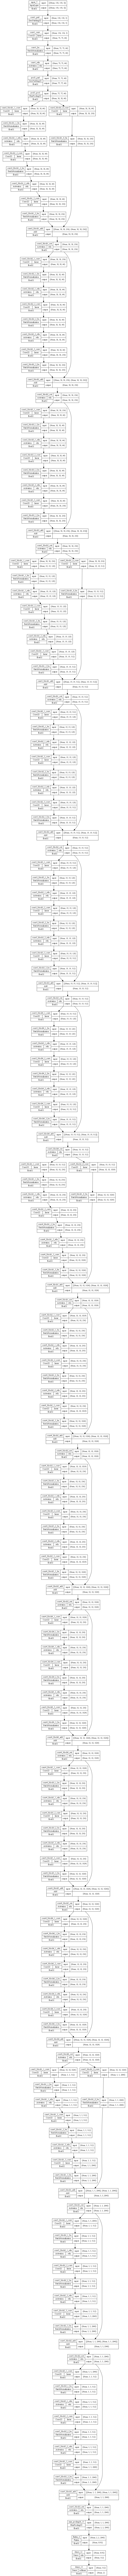

In [96]:
# Get a visual view of the architecture
keras.utils.plot_model(modelresnet50, to_file='arsitektur-model/modelresnet50.png', show_shapes=True, show_dtype=True, 
                       show_layer_names=True, expand_nested=True,
                       dpi=75, show_layer_activations=True,
)

In [97]:
# tell the model what cost and optimization method to use
modelresnet50.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [98]:
# fit the model
modelresnet50.fit(train_data,
              validation_data=validate_data,
              epochs=15,
              steps_per_epoch=len(train_data),
              validation_steps=len(validate_data),
              callbacks=[es])

Epoch 1/15
700/700 [==============================] - 160s 214ms/step - loss: 1.5975 - accuracy: 0.5357 - val_loss: 82.7320 - val_accuracy: 0.5950
Epoch 2/15
700/700 [==============================] - 147s 210ms/step - loss: 0.6853 - accuracy: 0.5957 - val_loss: 0.6710 - val_accuracy: 0.6000
Epoch 3/15
700/700 [==============================] - 145s 207ms/step - loss: 0.6770 - accuracy: 0.5957 - val_loss: 0.6697 - val_accuracy: 0.5950
Epoch 4/15
700/700 [==============================] - 153s 219ms/step - loss: 0.6756 - accuracy: 0.5957 - val_loss: 0.6684 - val_accuracy: 0.6000
Epoch 5/15
700/700 [==============================] - 160s 229ms/step - loss: 0.6753 - accuracy: 0.5957 - val_loss: 0.6689 - val_accuracy: 0.6000
Epoch 6/15
700/700 [==============================] - 153s 218ms/step - loss: 0.8239 - accuracy: 0.6000 - val_loss: 1.0398 - val_accuracy: 0.5800
Epoch 7/15
700/700 [==============================] - 148s 211ms/step - loss: 0.7162 - accuracy: 0.5857 - val_loss: 0.6752 

In [99]:
# Creating dataframe of losses and accuracies of model
losses = modelresnet50.history.history
df_loss = pd.DataFrame(losses)

In [100]:
df_loss.sort_values(by='val_accuracy',ascending=False).head()

,loss,accuracy,val_loss,val_accuracy
1,0.685295,0.595714,0.670996,0.600
3,0.675551,0.595714,0.668362,0.600
4,0.675309,0.595714,0.668946,0.600
0,1.597484,0.535714,82.731956,0.595
2,0.677009,0.595714,0.669686,0.595


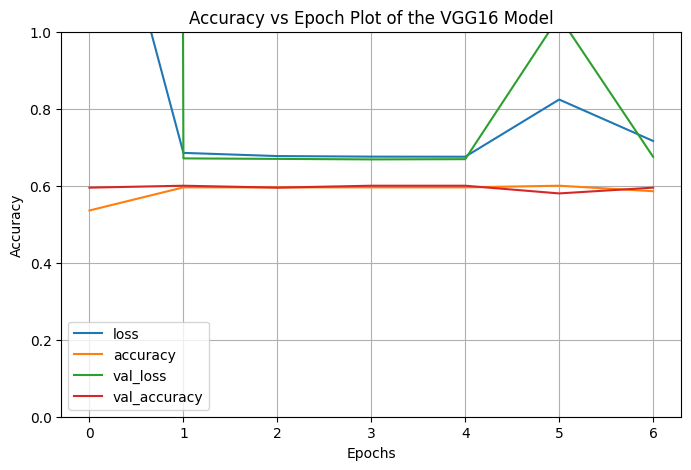

In [101]:
# Visualizing the performance of model
pd.DataFrame(modelresnet50.history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_ylim(0, 1)
plt.title('Accuracy vs Epoch Plot of the VGG16 Model')
plt.show()

In [102]:
# Evaluasi model
loss, accuracy= modelresnet50.evaluate(test_data)
print(f'Accuracy: {accuracy*100}')

102/102 [==============================] - 5s 51ms/step - loss: 0.6740 - accuracy: 0.5980
Accuracy: 59.80392098426819


In [106]:
modelresnet50.save('model/modelresnet50.h5')

### Predict

1/1 [==============================] - 4s 4s/step
prediksi: Pisang Kulit Tidak Luka
persentase prediksi: 51.90 %


prediksi:	Pisang Kulit Luka
persentase:	48.10 %
prediksi:	Pisang Kulit Tidak Luka
persentase:	51.90 %


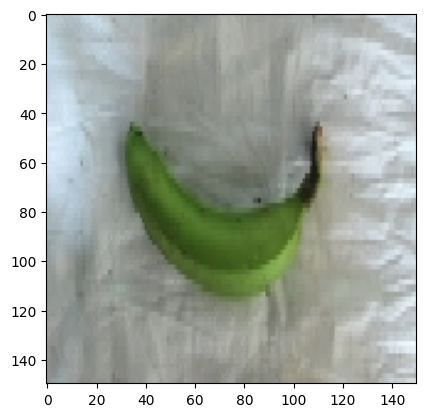

In [9]:
class_names =  ["Pisang Kulit Luka", "Pisang Kulit Tidak Luka"]

image_path = "dataset/test/pisang-kulit-tidak-luka/IMG_0034.jpg"
new_img = image.load_img(image_path, target_size=(150, 150))
img = image.img_to_array(new_img)/255
img = np.expand_dims(img, axis=0)

images = np.vstack([img])

prediction = model.predict(images, batch_size=10)
predictions = np.argmax(prediction,axis=1)

print('prediksi: {}'.format(class_names[predictions[0]]))
print('persentase prediksi: {:.2f} %'.format(np.max(prediction)*100))
print('\n')
for i in range(len(class_names)):
    print('prediksi:\t{}'. format(class_names[i]))
    print("persentase:\t{:.2f} %".format(prediction[0][i]*100))

plt.imshow(new_img)

### Load Model

In [52]:
# For load the model you can use the code
from keras.models import load_model 
model = load_model('model/modelcnn.h5')

In [63]:
class_names = list(test_data.class_indices.keys())

In [64]:
class_names

['pisang-kulit-luka', 'pisang-kulit-tidak-luka']

In [53]:
test_pred = model.predict(test_data)

102/102 [==============================] - 1s 4ms/step


In [54]:
test_pred

array([[8.8689363e-01, 1.1310640e-01],
       [3.4766793e-01, 6.5233207e-01],
       [7.6294494e-01, 2.3705502e-01],
       [6.5972918e-01, 3.4027079e-01],
       [3.3072252e-02, 9.6692777e-01],
       [5.4101789e-01, 4.5898214e-01],
       [4.7840169e-01, 5.2159834e-01],
       [1.5092044e-04, 9.9984908e-01],
       [4.8213837e-01, 5.1786160e-01],
       [8.1489247e-01, 1.8510759e-01],
       [4.7840169e-01, 5.2159834e-01],
       [7.7223784e-01, 2.2776216e-01],
       [4.7840169e-01, 5.2159834e-01],
       [7.1477568e-01, 2.8522435e-01],
       [1.3251810e-01, 8.6748189e-01],
       [4.7840169e-01, 5.2159834e-01],
       [2.1958031e-01, 7.8041971e-01],
       [4.9111596e-01, 5.0888407e-01],
       [4.7840169e-01, 5.2159834e-01],
       [5.3354584e-02, 9.4664538e-01],
       [4.4759849e-04, 9.9955243e-01],
       [3.0390403e-01, 6.9609594e-01],
       [6.2685037e-01, 3.7314969e-01],
       [4.7840169e-01, 5.2159834e-01],
       [4.7840169e-01, 5.2159834e-01],
       [4.5061833e-01, 5.

In [55]:
test_labels = test_data.classes

In [56]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [57]:
# import libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# create confusion matrix
cm = confusion_matrix(test_labels, np.argmax(test_pred, axis=1))
# confusion_matrix = confusion_matrix(y_pred, test_data)
print(cm)
# print(classification_report(Y_train, prediction_train))

[[24 37]
 [15 26]]


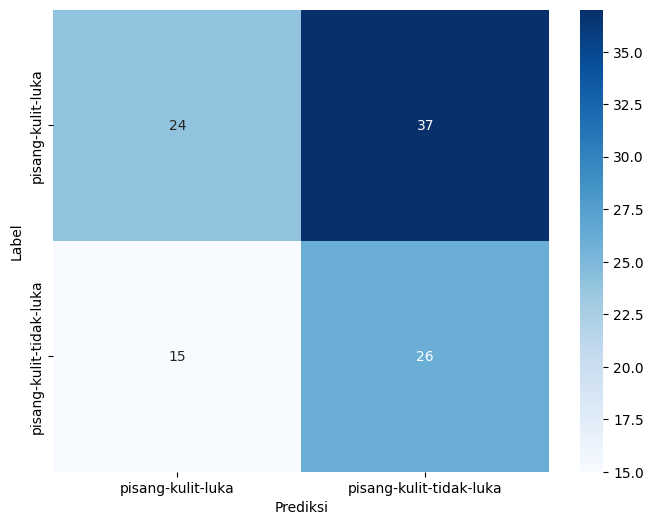

In [68]:
import seaborn as sns

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prediksi")
plt.ylabel("Label")
plt.show()

In [67]:
class_names = list(test_data.class_indices.keys())
report = classification_report(test_labels, np.argmax(test_pred, axis=1), target_names=class_names)
print(report)

                         precision    recall  f1-score   support

      pisang-kulit-luka       0.62      0.39      0.48        61
pisang-kulit-tidak-luka       0.41      0.63      0.50        41

               accuracy                           0.49       102
              macro avg       0.51      0.51      0.49       102
           weighted avg       0.53      0.49      0.49       102

